In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
import numpy as np
import optax
from flax.linen.initializers import constant, orthogonal
from typing import Sequence, NamedTuple, Any
from flax.training.train_state import TrainState
import distrax
import gymnax
from gymnax.wrappers.purerl import LogWrapper, FlattenObservationWrapper
import time

import matplotlib.pyplot as plt

In [2]:
class BCAgent(nn.Module):
    """Network architecture. Matches MinAtar PPO agent from PureJaxRL"""

    action_dim: Sequence[int]
    activation: str = "tanh"
    width: int = 64

    @nn.compact
    def __call__(self, x):
        if self.activation == "relu":
            activation = nn.relu
        else:
            activation = nn.tanh
        actor_mean = nn.Dense(
            self.width, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(x)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.width, kernel_init=orthogonal(np.sqrt(2)), bias_init=constant(0.0)
        )(actor_mean)
        actor_mean = activation(actor_mean)
        actor_mean = nn.Dense(
            self.action_dim, kernel_init=orthogonal(0.01), bias_init=constant(0.0)
        )(actor_mean)
        #         pi = distrax.Categorical(logits=actor_mean)

        return actor_mean


class Transition(NamedTuple):
    done: jnp.ndarray
    action: jnp.ndarray
    value: jnp.ndarray
    reward: jnp.ndarray
    log_prob: jnp.ndarray
    obs: jnp.ndarray
    info: jnp.ndarray

# Behavioural Cloning Training Loop

In [3]:
def make_train(config):
    """Create training function based on config."""
    config["NUM_UPDATES"] = config["UPDATE_EPOCHS"]

    env, env_params = gymnax.make(config["ENV_NAME"])
    env = FlattenObservationWrapper(env)
    env = LogWrapper(env)

    # Do I need a schedule on the LR for BC?
    def linear_schedule(count):
        frac = 1.0 - (count // config["NUM_UPDATES"])
        return config["LR"] * frac

    def train(synth_data, action_labels, rng):
        """Train using BC on synthetic data with fixed action labels and evaluate on RL environment"""

        # 1. INIT NETWORK AND TRAIN STATE
        network = BCAgent(
            env.action_space(env_params).n, activation=config["ACTIVATION"], width=config["WIDTH"]
        )
        rng, _rng = jax.random.split(rng)
        init_x = jnp.zeros(env.observation_space(env_params).shape)
        network_params = network.init(_rng, init_x)

        assert (
            synth_data[0].shape == env.observation_space(env_params).shape
        ), f"Data of shape {synth_data[0].shape} does not match env observations of shape {env.observation_space(env_params).shape}"

        # Setup optimizer
        if config["ANNEAL_LR"]:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(learning_rate=linear_schedule, eps=1e-5),
            )
        else:
            tx = optax.chain(
                optax.clip_by_global_norm(config["MAX_GRAD_NORM"]),
                optax.adam(config["LR"], eps=1e-5),
            )

        # Train state carries everything needed for NN training
        train_state = TrainState.create(
            apply_fn=network.apply,
            params=network_params,
            tx=tx,
        )

        # 2. BC TRAIN LOOP
        def _bc_train(train_state, rng):
            def _bc_update_step(bc_state, unused):
                train_state, rng = bc_state

                def _loss_and_acc(params, apply_fn, step_data, y_true, num_classes):
                    """Compute cross-entropy loss and accuracy."""
                    y_pred = apply_fn(params, step_data)
                    acc = jnp.mean(jnp.argmax(y_pred, axis=-1) == y_true)
                    labels = jax.nn.one_hot(y_true, num_classes)
                    loss = -jnp.sum(labels * jax.nn.log_softmax(y_pred))
                    loss /= labels.shape[0]
                    return loss, acc

                grad_fn = jax.value_and_grad(_loss_and_acc, has_aux=True)

                # Not needed if using entire dataset
                rng, perm_rng = jax.random.split(rng)
                perm = jax.random.permutation(perm_rng, len(action_labels))
                step_data = synth_data[perm]
                y_true = action_labels[perm]

                loss_and_acc, grads = grad_fn(
                    train_state.params,
                    train_state.apply_fn,
                    step_data,
                    y_true,
                    env.action_space().n,
                )
                train_state = train_state.apply_gradients(grads=grads)
                bc_state = (train_state, rng)
                return bc_state, loss_and_acc

            bc_state = (train_state, rng)
            bc_state, loss_and_acc = jax.lax.scan(
                _bc_update_step, bc_state, None, config["UPDATE_EPOCHS"]
            )
            loss, acc = loss_and_acc
            return bc_state, loss, acc

        rng, _rng = jax.random.split(rng)
        bc_state, bc_loss, bc_acc = _bc_train(train_state, _rng)
        train_state = bc_state[0]

        # Init envs
        rng, _rng = jax.random.split(rng)
        reset_rng = jax.random.split(_rng, config["NUM_ENVS"])
        obsv, env_state = jax.vmap(env.reset, in_axes=(0, None))(reset_rng, env_params)

        # 3. POLICY EVAL LOOP
        def _eval_ep(runner_state):
            # Environment stepper
            def _env_step(runner_state, unused):
                train_state, env_state, last_obs, rng = runner_state

                # Select Action
                rng, _rng = jax.random.split(rng)
                pi = train_state.apply_fn(train_state.params, last_obs)
                if config["GREEDY_ACT"]:
                    action = pi.argmax(
                        axis=-1
                    )  # if 2+ actions are equiprobable, returns first
                else:
                    probs = distrax.Categorical(logits=pi)
                    action = probs.sample(seed=_rng)

                # Step env
                rng, _rng = jax.random.split(rng)
                rng_step = jax.random.split(_rng, config["NUM_ENVS"])

                obsv, env_state, reward, done, info = jax.vmap(
                    env.step, in_axes=(0, 0, 0, None)
                )(rng_step, env_state, action, env_params)
                transition = Transition(
                    done, action, -1, reward, jax.nn.log_softmax(pi), last_obs, info
                )
                runner_state = (train_state, env_state, obsv, rng)
                return runner_state, transition

            runner_state, traj_batch = jax.lax.scan(
                _env_step, runner_state, None, config["NUM_STEPS"]
            )
            metric = traj_batch.info
            return runner_state, metric

        rng, _rng = jax.random.split(rng)
        runner_state = (train_state, env_state, obsv, _rng)
        runner_state, metric = _eval_ep(runner_state)

        metric["bc_loss"] = bc_loss
        metric["bc_accuracy"] = bc_acc

        return {"runner_state": runner_state, "metrics": metric}

    return train

# Meta-learning the Dataset

## Setup

In [4]:
from evosax import OpenES, ParameterReshaper

config = {
    "LR": 5e-2,  # 5e-3      # 2.5e-2 to 5e-2 brings BC loss to ~0 for UPDATE_EPOCHS=10 and up to 100 states/action
    "NUM_ENVS": 16,   #8 # Num eval envs
    "NUM_STEPS": 512,   #128 # Max num eval steps per env
    "UPDATE_EPOCHS": 10,  # Num BC gradient steps
    "MAX_GRAD_NORM": 0.5,
    "ACTIVATION": "relu",
    "WIDTH" : 64,
    "ENV_NAME": "CartPole-v1",
    "ANNEAL_LR": True,
    "GREEDY_ACT": True,  # Whether to use greedy act in env or sample
}

In [5]:
env, env_params = gymnax.make(config["ENV_NAME"])
env = FlattenObservationWrapper(env)
env = LogWrapper(env)

n_actions = env.action_space(env_params).n

es_config = {
    "popsize": 500,  # Num of candidates
    "dataset_size": n_actions * 1, #10 #20000,  # Num of (s,a) pairs (split evenly across actions)
    "rollouts_per_candidate": 2,  #32 Num of BC policies trained per candidate
    "n_generations": 10,
    "log_interval": 1,
}

params = jnp.zeros(
    (es_config["dataset_size"], *env.observation_space(env_params).shape)
)
param_reshaper = ParameterReshaper(params)

ParameterReshaper: 8 parameters detected for optimization.


## Sampling real data

In [16]:
from tqdm import tqdm
rng = jax.random.PRNGKey(0)
# rng, reset_rng = jax.random.split(rng)
# obs, env_state = env.reset(reset_rng, env_params)

# obs_list = []
# action_list = []
# dones_list = []

# # Small chance of not gathering enough data, but it doesn't matter in practice
# for t in tqdm(range(es_config["dataset_size"] * 10)):
#     rng, rng_act, rng_step = jax.random.split(rng, 3)
#     action = jax.random.choice(rng_act, a=jnp.arange(n_actions))
#     action_list.append(action.item())
    
#     obs, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params)
#     obs_list.append(obs)    
    
# action_list = jnp.array(action_list)
# obs_list = jnp.array(obs_list)

In [17]:
# dataset = []
# for a in range(n_actions):
#     obs_for_action = obs_list[action_list == a]
#     rng, rng_shuffle = jax.random.split(rng)
#     dataset.append(jax.random.shuffle(rng_shuffle, obs_for_action, axis=0)[0:es_config["dataset_size"]//n_actions])
    
# sampled_data = jnp.array(dataset).flatten()
# sampled_data.shape

In [18]:
# sampled_data.reshape(2,4)

## Initialize Strategy

In [19]:
# Initialize OpenES Strategy
# rng = jax.random.PRNGKey(0)
rng, rng_init = jax.random.split(rng)

strategy = OpenES(
    popsize=es_config["popsize"],
    num_dims=param_reshaper.total_params,
    opt_name="adam",
    maximize=True,
)

# Replace state mean with real observations
# state = state.replace(mean = sampled_data)


def get_action_labels(d_size, n_actions):
    action_labels = jnp.array([i % n_actions for i in range(d_size)])
    action_labels = action_labels.sort()
    return action_labels


# Set up vectorized fitness function
train_fn = make_train(config)
action_labels = get_action_labels(es_config["dataset_size"], n_actions)


def single_seed_BC(rng_input, dataset):
    out = train_fn(dataset, action_labels, rng_input)
    return out  # ["metrics"]['returned_episode_returns'].mean()


multi_seed_BC = jax.vmap(single_seed_BC, in_axes=(0, None))  # Vectorize over seeds
train_and_eval = jax.jit(jax.vmap(multi_seed_BC, in_axes=(None, 0)))  # Vectorize over datasets

if len(jax.devices()) > 1:
    train_and_eval = jax.pmap(train_and_eval, in_axes=(None, 0))

## Run OpenES loop

In [20]:
start = time.time()
lap_start = start
fitness_over_gen = []
max_fitness_over_gen = []
for gen in range(es_config["n_generations"]):
    # Gen new dataset
    rng, rng_ask, rng_inner = jax.random.split(rng, 3)
    datasets, state = jax.jit(strategy.ask)(rng_ask, state, es_params)
    # Eval fitness
    batch_rng = jax.random.split(rng_inner, es_config["rollouts_per_candidate"])
    # Preemptively overwrite to reduce memory load
    out = None
    returns = None
    dones = None
    fitness = None
    shaped_datasets = None

    with jax.disable_jit(False):
        shaped_datasets = param_reshaper.reshape(datasets)
        out = train_and_eval(batch_rng, shaped_datasets)

        returns = out["metrics"]["returned_episode_returns"]  # dim=(popsize, rollouts, num_steps, num_envs)
        dones = out["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise
        
        # Division by zero, you idiot
        fitness = (returns * dones).sum(axis=(-1, -2, -3)) / dones.sum(axis=(-1, -2, -3))  # fitness, dim = (popsize)
        fitness = fitness.flatten()    # Necessary if pmap-ing to 2+ devices

    # Update ES strategy with fitness info
    state = jax.jit(strategy.tell)(datasets, fitness, state, es_params)
    fitness_over_gen.append(fitness.mean())
    max_fitness_over_gen.append(fitness.max())

    if gen % es_config["log_interval"] == 0 or gen == 0:
        lap_end = time.time()
        if len(jax.devices()) > 1:
            bc_loss = out["metrics"]["bc_loss"][:,:,:,-1]
            bc_acc = out["metrics"]["bc_accuracy"][:,:,:,-1]
        else:
            bc_loss = out["metrics"]["bc_loss"][:,:,-1]
            bc_acc = out["metrics"]["bc_accuracy"][:,:,-1]
        
        print(
            f"Gen: {gen}, Fitness: {fitness.mean():.2f} +/- {fitness.std():.2f}, "
            + f"Best: {state.best_fitness:.2f}, BC loss: {bc_loss.mean():.2f} +/- {bc_loss.std():.2f}, "
            + f"BC acc: {bc_acc.mean():.2f} +/- {bc_acc.std():.2f}, Lap time: {lap_end-lap_start:.1f}s"
        )
        lap_start = lap_end
print(f"Total time: {(lap_end-start)/60:.1f}min")


Gen: 0, Fitness: 482.25 +/- 30.46, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 7.3s
Gen: 1, Fitness: 499.29 +/- 4.98, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 3.9s
Gen: 2, Fitness: 499.92 +/- 0.45, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 4.0s
Gen: 3, Fitness: 490.61 +/- 18.19, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 4.0s
Gen: 4, Fitness: 499.95 +/- 1.02, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 3.8s
Gen: 5, Fitness: 488.37 +/- 22.46, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 4.0s
Gen: 6, Fitness: 450.10 +/- 30.96, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 4.5s
Gen: 7, Fitness: 499.28 +/- 4.45, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 4.0s
Gen: 8, Fitness: 499.82 +/- 2.11, Best: 500.00, BC loss: 0.00 +/- 0.00, BC acc: 1.00 +/- 0.00, Lap time: 4.8s
Gen: 9

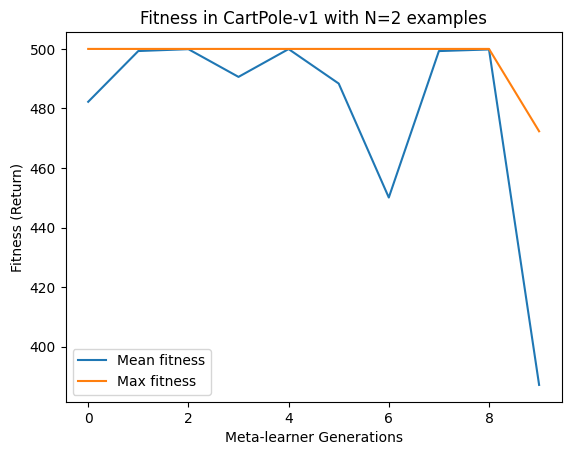

In [26]:
from scipy.signal import savgol_filter
# savgol_filter(y, 20, 3)

y = fitness_over_gen
plt.plot(fitness_over_gen, label="Mean fitness")
y = max_fitness_over_gen
plt.plot(max_fitness_over_gen, label="Max fitness")
plt.title(f"Fitness in CartPole-v1 with N={es_config['dataset_size']} examples")
plt.ylabel("Fitness (Return)")
plt.xlabel("Meta-learner Generations")
plt.legend()
plt.show()

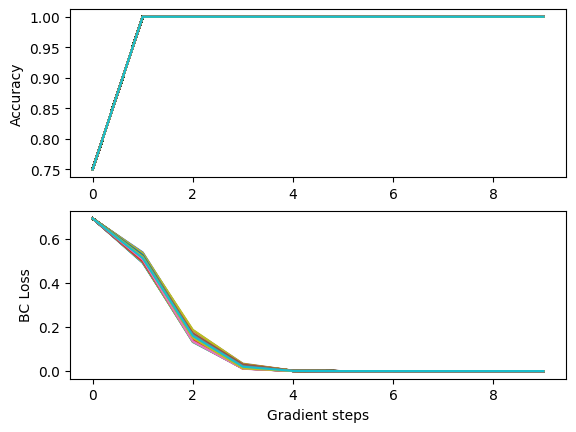

In [31]:
def reshape(arr):
    """Removes extra dim due to pmap"""
    dims = arr.shape
    arr = arr.reshape(-1,dims[-2],dims[-1])
    return arr

fig, ax = plt.subplots(2, 1)
for i in range(es_config["popsize"]):
    acc = reshape(out["metrics"]["bc_accuracy"])[i].mean(axis=0)
    ax[0].plot(acc)
    ax[0].set_ylabel("Accuracy")

    loss = reshape(out["metrics"]["bc_loss"])[i].mean(axis=0)
    ax[1].plot(loss)
    ax[1].set_ylabel("BC Loss")
    ax[1].set_xlabel("Gradient steps")

## Double check policy return

In [39]:
P = es_config["popsize"]
final_datasets_reshaped = param_reshaper.reshape(datasets)

best = fitness.argmax()

if len(jax.devices()) > 1:
    best_idx = (best // (P//2), best % (P//2))
else:
    best_idx = (best % (P//2))

final_dataset = final_datasets_reshaped[best_idx]

print("Final dataset:")
final_dataset

Final dataset:


Array([[-0.21549506, -0.20574546, -0.4971618 , -0.37629485],
       [-0.19004558,  0.22649032,  0.4691167 ,  0.47763544]],      dtype=float32)

In [40]:
P = es_config["popsize"]
final_datasets_reshaped = param_reshaper.reshape(datasets)

best = fitness.argmax()

final_dataset = final_datasets_reshaped[ best_idx]

print("Final dataset:")
final_dataset

Final dataset:


Array([[-0.21549506, -0.20574546, -0.4971618 , -0.37629485],
       [-0.19004558,  0.22649032,  0.4691167 ,  0.47763544]],      dtype=float32)

In [41]:
train_state = out["runner_state"][0]
# Note: if multiple rollouts / candidate, pick first rollout
f = lambda x : x[best_idx, 0]
best_params = jax.tree_util.tree_map(f, train_state.params)

best_ret = returns[best_idx]
best_dones = dones[best_idx]

best_mean_ret  = (best_ret * best_dones).sum(axis=(-1, -2)) /best_dones.sum(axis=(-1, -2))
print("Best mean return per rollout", best_mean_ret)

Best mean return per rollout [444.6875 500.    ]


In [42]:
env, env_params = gymnax.make(config["ENV_NAME"])
# env = FlattenObservationWrapper(env)
# env = LogWrapper(env)

n_actions = env.action_space(env_params).n

rng = jax.random.PRNGKey(42)
rng, reset_rng = jax.random.split(rng)
obs, env_state = env.reset(reset_rng, env_params)

rewards_per_ep = []

for t in tqdm(range(512)):
    rng, rng_act, rng_step = jax.random.split(rng, 3)
    
    pi = train_state.apply_fn(best_params, obs)
    action = pi.argmax(axis=-1)
    
    obs, env_state, reward, done, info = env.step(rng_step, env_state, action, env_params) 
    rewards_per_ep.append(reward)
    if done:
        ep_ret = jnp.array(rewards_per_ep).sum()
        print("Ep return: ", ep_ret)
        rewards_per_ep = []


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 445/512 [00:06<00:01, 52.42it/s]

Ep return:  431.0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 512/512 [00:07<00:00, 64.44it/s]


In [43]:
def render_cartpole(state, env_params):
    import pygame
    from pygame import gfxdraw
    
    screen_width = 600
    screen_height = 400
    length = 0.5 
    x_threshold = 2.4
    
    render_mode = "rgb_array"

    pygame.init()
    screen = pygame.Surface((screen_width, screen_height))
    clock = pygame.time.Clock()

    world_width = x_threshold * 2
    scale = screen_width / world_width
    polewidth = 10.0
    polelen = scale * (2 * length)
    cartwidth = 50.0
    cartheight = 30.0
    tau = env_params.tau

    if state is None:
        return None

    x = state

    surf = pygame.Surface((screen_width, screen_height))
    surf.fill((255, 255, 255))
    
    
    for draw_mode in [0,1]:
        
        l, r, t, b = -cartwidth / 2, cartwidth / 2, cartheight / 2, -cartheight / 2
        axleoffset = cartheight / 4.0
    
        cartx = (x[0] + tau*x[1]*draw_mode) * scale + screen_width / 2.0  # MIDDLE OF CART
        carty = 100  # TOP OF CART
        cart_coords = [(l, b), (l, t), (r, t), (r, b)]
        cart_coords = [(c[0] + cartx, c[1] + carty) for c in cart_coords]
        gfxdraw.aapolygon(surf, cart_coords, (0, 0, 0, 250-draw_mode*150))
        gfxdraw.filled_polygon(surf, cart_coords, (0, 0, 0, 250-draw_mode*150))

        l, r, t, b = (
            -polewidth / 2,
            polewidth / 2,
            polelen - polewidth / 2,
            -polewidth / 2,
        )

        pole_coords = []
        for coord in [(l, b), (l, t), (r, t), (r, b)]:
            coord = pygame.math.Vector2(coord).rotate_rad(-(x[2] + tau*x[3]*draw_mode))
            coord = (coord[0] + cartx, coord[1] + carty + axleoffset)
            pole_coords.append(coord)
        gfxdraw.aapolygon(surf, pole_coords, (202, 152, 101, 250-draw_mode*150))
        gfxdraw.filled_polygon(surf, pole_coords, (202, 152, 101, 250-draw_mode*150))

        gfxdraw.aacircle(
            surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203, 200-draw_mode*120),
        )
        gfxdraw.filled_circle(
            surf,
            int(cartx),
            int(carty + axleoffset),
            int(polewidth / 2),
            (129, 132, 203, 200-draw_mode*120),
        )

        gfxdraw.hline(surf, 0, screen_width, carty, (0, 0, 0))

    surf = pygame.transform.flip(surf, False, True)
    screen.blit(surf, (0, 0))

    return np.transpose(
        np.array(pygame.surfarray.pixels3d(screen)), axes=(1, 0, 2)
    )

ModuleNotFoundError: No module named 'pygame'

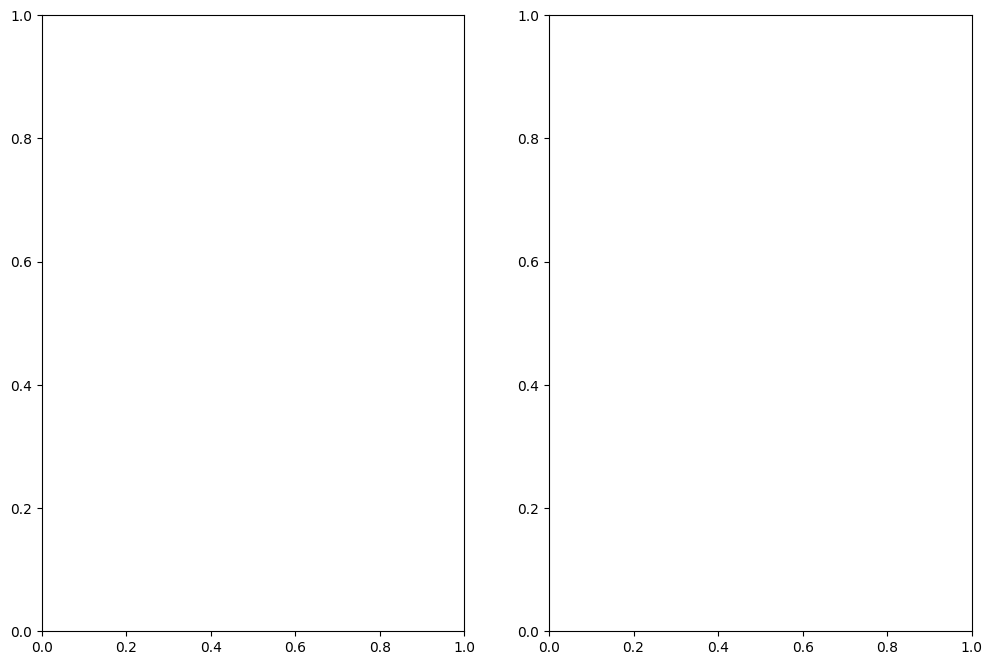

In [44]:
fig, ax = plt.subplots(1,2, figsize=(12,8))

for i, synth_state in enumerate(final_dataset):
    img = render_cartpole(synth_state, env_params)
    ax[i].imshow(img, label="hello")
    ax[i].set_title(f"action = {action_labels[i]}")
    
    x_dot = synth_state[1].item()
    theta_dot = synth_state[3].item()
    
    print(synth_state)
    
    ax[i].set_xticks([0, 500/2, 500], [-4.8, 0, 4.8])
    ax[i].text(490, 60, f"v={x_dot:.2f}, \ndθ={theta_dot:.2f}", bbox=dict(fill=False, edgecolor='red', linewidth=2))

## TODO:

1. Investigate nan / fitness computation for CartPole
    - Division by zero if episodes not done


## Generalization

In [51]:
width_list = [2,4,8,16,32,64,128,256]
fit_list = []
for width in width_list:
    new_config = config.copy()
    new_config["WIDTH"] = width
    new_config["UPDATE_EPOCHS"] = 10
    
    num_envs = 20

    final_dataset # Given
    action_labels # Given

    new_train_fn = make_train(new_config)

    def new_BC_train(rng_input, dataset):
        out = new_train_fn(dataset, action_labels, rng_input)
        return out  # ["metrics"]['returned_episode_returns'].mean()
    
    vmapped_BC_train = jax.jit(jax.vmap(new_BC_train, in_axes=(0, None)))
    
    rng, rng_new = jax.random.split(rng)
    rng_batch = jax.random.split(rng_new, num_envs)

    out_new = vmapped_BC_train(rng_batch, final_dataset)

    returns = out_new["metrics"]["returned_episode_returns"]  # dim=(popsize, rollout_news, num_steps, num_envs)
    dones = out_new["metrics"]["returned_episode"]  # same dim, True for last steps, False otherwise
    fitness = (returns * dones).sum(axis=(-1,-2)) / dones.sum(axis=(-1,-2))  # fitness, dim = (popsize)
    
    bc_loss = out_new['metrics']['bc_loss'][:,-1]
    
    fit_list.append(fitness)
    print(f"Width {width} : fitness={fitness.mean():.1f} +/- {fitness.std():.1f}")#, loss={bc_loss.mean():.2f} +/- {bc_loss.std():.2f}")
    

Width 2 : fitness=102.4 +/- 148.7
Width 4 : fitness=165.2 +/- 140.9
Width 8 : fitness=267.0 +/- 195.3
Width 16 : fitness=399.8 +/- 150.4
Width 32 : fitness=486.8 +/- 32.6
Width 64 : fitness=500.0 +/- 0.0
Width 128 : fitness=488.0 +/- 52.1
Width 256 : fitness=500.0 +/- 0.0


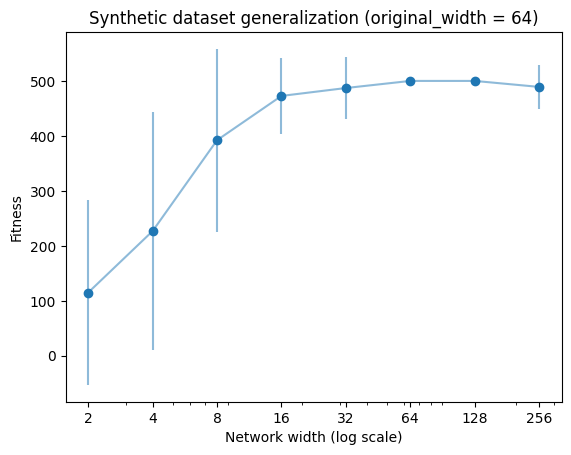

In [50]:
plt.scatter(width_list, [x.mean() for x in fit_list])

means = jnp.array([x.mean() for x in fit_list])
stds = jnp.array([x.std() for x in fit_list])

plt.errorbar(width_list, means, stds, alpha=0.5)
plt.ylabel("Fitness")
plt.xlabel("Network width (log scale)")
plt.xscale("log")
plt.xticks(width_list, width_list)
plt.title("Synthetic dataset generalization (original_width = 64)")
plt.show()